# Notebook 04: Train Simple CNN

**Mục đích:** Train Simple CNN baseline deep learning model.

**Input:**
- `data/patches/patches_64x64.pkl` (1,285 patches)

**Output:**
- `models/simple_cnn_best.pth` (best model checkpoint)
- `results/simple_cnn_results.json` (metrics + training history)
- `figures/simple_cnn_training.png` (training curves)

**Thời gian ước tính:** ~2-4 giờ (30-40 epochs trên GTX 1060)

---

## Model Architecture:
```
Input: (18, 64, 64)
→ Conv Block 1: 18→32 + BN + ReLU + MaxPool + Dropout(0.3)
→ Conv Block 2: 32→64 + BN + ReLU + MaxPool + Dropout(0.3)
→ Conv Block 3: 64→128 + BN + ReLU + MaxPool + Dropout(0.4)
→ Conv Block 4: 128→256 + BN + ReLU + MaxPool + Dropout(0.5)
→ Global Avg Pool
→ FC: 256→128→2
```

**Parameters:** ~1.2M

## Training Configuration:
- **Batch size:** 24
- **Gradient accumulation:** 2 steps (effective BS = 48)
- **Optimizer:** AdamW (lr=1e-3, weight_decay=1e-4)
- **Scheduler:** ReduceLROnPlateau
- **Mixed Precision (AMP):** Enabled
- **Early stopping:** Patience = 15 epochs

In [1]:
# Import libraries
import sys
sys.path.append('..')

import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from src.config import PATCHES_DIR
from src.models import SimpleCNN, count_parameters

# Check GPU
print("="*70)
print("SYSTEM CHECK")
print("="*70)
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("⚠️ Warning: CUDA not available. Training will be VERY SLOW on CPU!")
print("="*70)

SYSTEM CHECK
PyTorch version: 2.5.1+cu118
CUDA available: True
CUDA version: 11.8
GPU: NVIDIA GeForce GTX 1060 6GB
GPU Memory: 6.44 GB


## 1. Load and Verify Patches

In [2]:
from src.dataset import load_patches

patches_file = PATCHES_DIR / "patches_64x64.pkl"

if not patches_file.exists():
    print(f"❌ Error: Patches file not found at {patches_file}")
    print("Please run notebook 02_create_patches.ipynb first!")
else:
    patches, labels = load_patches(patches_file)
    print(f"\n✓ Successfully loaded {len(patches)} patches")
    print(f"  - Shape: {patches.shape}")
    print(f"  - Data type: {patches.dtype}")
    print(f"  - Memory: {patches.nbytes / 1e6:.2f} MB")

Loaded 1280 patches from d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\data\patches\patches_64x64.pkl
  - Shape: (1280, 18, 64, 64)
  - Labels: (array([0, 1]), array([645, 635]))

✓ Successfully loaded 1280 patches
  - Shape: (1280, 18, 64, 64)
  - Data type: float32
  - Memory: 377.49 MB


## 2. Create Model and Check Architecture

In [3]:
from src.config import TOTAL_INPUT_CHANNELS, NUM_CLASSES

# Create model
model = SimpleCNN(in_channels=TOTAL_INPUT_CHANNELS, num_classes=NUM_CLASSES)

# Count parameters
total_params, trainable_params = count_parameters(model)

print("="*70)
print("MODEL ARCHITECTURE: SimpleCNN")
print("="*70)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model size: {total_params / 1e6:.2f}M parameters")

# Test forward pass
dummy_input = torch.randn(2, TOTAL_INPUT_CHANNELS, 64, 64)
with torch.no_grad():
    dummy_output = model(dummy_input)

print(f"\nForward pass test:")
print(f"  Input shape:  {dummy_input.shape}")
print(f"  Output shape: {dummy_output.shape}")
print(f"\n✓ Model architecture verified!")

MODEL ARCHITECTURE: SimpleCNN

Total parameters: 426,850
Trainable parameters: 426,850
Model size: 0.43M parameters

Forward pass test:
  Input shape:  torch.Size([2, 18, 64, 64])
  Output shape: torch.Size([2, 2])

✓ Model architecture verified!


## 3. Memory Estimation

Ước tính VRAM sử dụng với batch size = 24:

In [4]:
from src.config import BATCH_SIZE, USE_AMP

# Estimate memory usage
bytes_per_param = 2 if USE_AMP else 4  # float16 vs float32

model_memory = total_params * bytes_per_param / 1e6  # MB
optimizer_memory = total_params * 4 * 2 / 1e6  # Adam has 2 states, float32
batch_memory = BATCH_SIZE * 18 * 64 * 64 * bytes_per_param / 1e6
gradient_memory = total_params * bytes_per_param / 1e6

total_estimated = model_memory + optimizer_memory + batch_memory + gradient_memory

print("="*70)
print("ESTIMATED VRAM USAGE (with AMP)" if USE_AMP else "ESTIMATED VRAM USAGE (no AMP)")
print("="*70)
print(f"\nModel weights:        {model_memory:6.1f} MB")
print(f"Optimizer states:     {optimizer_memory:6.1f} MB")
print(f"Batch activations:    {batch_memory:6.1f} MB")
print(f"Gradients:            {gradient_memory:6.1f} MB")
print(f"Misc (cuDNN, etc):    ~800.0 MB (estimated)")
print(f"{'-'*40}")
print(f"Total estimated:      {total_estimated + 800:6.1f} MB")
print(f"\n{'✓ Should fit in 6GB VRAM' if total_estimated + 800 < 5500 else '⚠️ May require reducing batch size'}")

ESTIMATED VRAM USAGE (with AMP)

Model weights:           0.9 MB
Optimizer states:        3.4 MB
Batch activations:       3.5 MB
Gradients:               0.9 MB
Misc (cuDNN, etc):    ~800.0 MB (estimated)
----------------------------------------
Total estimated:       808.7 MB

✓ Should fit in 6GB VRAM


## 4. Train Simple CNN

⚠️ **Warning:** This cell will take 2-4 hours to complete!

The training script will:
1. Create DataLoaders with caching optimization
2. Setup optimizer, scheduler, AMP, early stopping
3. Train for up to 100 epochs (early stopping will likely stop earlier)
4. Save best model based on validation loss
5. Evaluate on all splits
6. Generate visualizations

**Progress will be shown below. You can monitor GPU usage in another terminal with:**
```bash
watch -n 1 nvidia-smi
```

In [5]:
from src.train_cnn import train_simple_cnn
import time

print("="*70)
print("STARTING SIMPLE CNN TRAINING")
print("="*70)
print("\n⏱️ Estimated time: 2-4 hours")
print("\n💡 Tips:")
print("  - Close other applications to free up VRAM")
print("  - Monitor GPU with: watch -n 1 nvidia-smi")
print("  - Training will save best model automatically")
print("  - You can stop and resume using saved checkpoint")
print("\n" + "="*70)
print("\nPress Ctrl+C to stop training (best model will still be saved)\n")
print("="*70)

start_time = time.time()

try:
    model, results = train_simple_cnn(
        patches_file=patches_file,
        save_model=True,
        save_results=True
    )
    
    elapsed_time = time.time() - start_time
    print(f"\n✓ Training completed in {elapsed_time/3600:.2f} hours!")
    
except KeyboardInterrupt:
    print("\n⚠️ Training interrupted by user.")
    print("Best model checkpoint has been saved.")
    
except Exception as e:
    print(f"\n❌ Error during training: {e}")
    import traceback
    traceback.print_exc()

STARTING SIMPLE CNN TRAINING

⏱️ Estimated time: 2-4 hours

💡 Tips:
  - Close other applications to free up VRAM
  - Monitor GPU with: watch -n 1 nvidia-smi
  - Training will save best model automatically
  - You can stop and resume using saved checkpoint


Press Ctrl+C to stop training (best model will still be saved)

SIMPLE CNN - TRAINING

Using device: cuda
GPU: NVIDIA GeForce GTX 1060 6GB
CUDA Version: 11.8

[1/7] Loading patches and creating dataloaders...
Loaded 1280 patches from d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\data\patches\patches_64x64.pkl
  - Shape: (1280, 18, 64, 64)
  - Labels: (array([0, 1]), array([645, 635]))

Dataset split:
  - Train: 896 (70%)
  - Val: 192 (15%)
  - Test: 192 (15%)

DataLoader configuration:
  - Batch size: 24
  - Num workers: 4
  - Pin memory: True
  - Prefetch factor: 2
  - Gradient accumulation steps: 2
  - Effective batch size: 48

[2/7] Creating SimpleCNN model...
Model parameters:
  - Total: 426,850 (0.43M)
  - Trainabl

c:\tools\Anaconda3\envs\dang\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:209: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=USE_AMP)


Training configuration:
  - Optimizer: AdamW
  - Learning rate: 0.001
  - Weight decay: 0.0001
  - Loss function: CrossEntropyLoss
  - LR scheduler: ReduceLROnPlateau
  - Early stopping patience: 15
  - Mixed precision (AMP): True
  - Max epochs: 100

[4/7] Starting training...

Epoch [1/100]
--------------------------------------------------


Training:   0%|          | 0/38 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation:   0%|          | 0/8 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:119: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation: 100%|██████████| 8/8 [00:16<00:00,  2.08s/it]


Train Loss: 0.4088 | Train Acc: 0.8136
Val Loss:   0.5762 | Val Acc:   0.6667
Learning Rate: 0.001000
✓ Best model saved (Val Loss: 0.5762)

Epoch [2/100]
--------------------------------------------------


Training:   0%|          | 0/38 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation:   0%|          | 0/8 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:119: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation: 100%|██████████| 8/8 [00:00<00:00, 68.40it/s]


Train Loss: 0.2937 | Train Acc: 0.8828
Val Loss:   0.3028 | Val Acc:   0.8854
Learning Rate: 0.001000
✓ Best model saved (Val Loss: 0.3028)

Epoch [3/100]
--------------------------------------------------


Training:   0%|          | 0/38 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation:   0%|          | 0/8 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:119: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation: 100%|██████████| 8/8 [00:00<00:00, 74.10it/s]


Train Loss: 0.2509 | Train Acc: 0.9029
Val Loss:   0.2752 | Val Acc:   0.8854
Learning Rate: 0.001000
✓ Best model saved (Val Loss: 0.2752)

Epoch [4/100]
--------------------------------------------------


Training:   0%|          | 0/38 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation:   0%|          | 0/8 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:119: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation: 100%|██████████| 8/8 [00:00<00:00, 72.04it/s]


Train Loss: 0.2533 | Train Acc: 0.9007
Val Loss:   0.4073 | Val Acc:   0.8229
Learning Rate: 0.001000
EarlyStopping counter: 1 out of 15

Epoch [5/100]
--------------------------------------------------


Training:   0%|          | 0/38 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation:   0%|          | 0/8 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:119: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation: 100%|██████████| 8/8 [00:00<00:00, 66.13it/s]


Train Loss: 0.2340 | Train Acc: 0.8996
Val Loss:   0.2815 | Val Acc:   0.8854
Learning Rate: 0.001000
EarlyStopping counter: 2 out of 15

Epoch [6/100]
--------------------------------------------------


Training:   0%|          | 0/38 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation:   0%|          | 0/8 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:119: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation: 100%|██████████| 8/8 [00:00<00:00, 72.81it/s]


Train Loss: 0.2136 | Train Acc: 0.9174
Val Loss:   0.5884 | Val Acc:   0.7448
Learning Rate: 0.001000
EarlyStopping counter: 3 out of 15

Epoch [7/100]
--------------------------------------------------


Training:   0%|          | 0/38 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation:   0%|          | 0/8 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:119: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation: 100%|██████████| 8/8 [00:00<00:00, 68.08it/s]


Train Loss: 0.2084 | Train Acc: 0.9163
Val Loss:   0.2244 | Val Acc:   0.9010
Learning Rate: 0.001000
✓ Best model saved (Val Loss: 0.2244)

Epoch [8/100]
--------------------------------------------------


Training:   0%|          | 0/38 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation:   0%|          | 0/8 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:119: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation: 100%|██████████| 8/8 [00:00<00:00, 63.49it/s]


Train Loss: 0.2022 | Train Acc: 0.9275
Val Loss:   0.1804 | Val Acc:   0.9323
Learning Rate: 0.001000
✓ Best model saved (Val Loss: 0.1804)

Epoch [9/100]
--------------------------------------------------


Training:   0%|          | 0/38 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation:   0%|          | 0/8 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:119: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation: 100%|██████████| 8/8 [00:00<00:00, 68.40it/s]


Train Loss: 0.1755 | Train Acc: 0.9319
Val Loss:   0.1628 | Val Acc:   0.9375
Learning Rate: 0.001000
✓ Best model saved (Val Loss: 0.1628)

Epoch [10/100]
--------------------------------------------------


Training:   0%|          | 0/38 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation:   0%|          | 0/8 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:119: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation: 100%|██████████| 8/8 [00:00<00:00, 74.06it/s]


Train Loss: 0.1901 | Train Acc: 0.9275
Val Loss:   0.4814 | Val Acc:   0.7760
Learning Rate: 0.001000
EarlyStopping counter: 1 out of 15

Epoch [11/100]
--------------------------------------------------


Training:   0%|          | 0/38 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation:   0%|          | 0/8 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:119: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation: 100%|██████████| 8/8 [00:00<00:00, 59.23it/s]


Train Loss: 0.1693 | Train Acc: 0.9297
Val Loss:   0.2793 | Val Acc:   0.8958
Learning Rate: 0.001000
EarlyStopping counter: 2 out of 15

Epoch [12/100]
--------------------------------------------------


Training:   0%|          | 0/38 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation:   0%|          | 0/8 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:119: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation: 100%|██████████| 8/8 [00:00<00:00, 71.39it/s]


Train Loss: 0.1441 | Train Acc: 0.9475
Val Loss:   0.2730 | Val Acc:   0.8906
Learning Rate: 0.001000
EarlyStopping counter: 3 out of 15

Epoch [13/100]
--------------------------------------------------


Training:   0%|          | 0/38 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation:   0%|          | 0/8 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:119: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation: 100%|██████████| 8/8 [00:00<00:00, 76.19it/s]


Train Loss: 0.1434 | Train Acc: 0.9431
Val Loss:   0.2089 | Val Acc:   0.9219
Learning Rate: 0.001000
EarlyStopping counter: 4 out of 15

Epoch [14/100]
--------------------------------------------------


Training:   0%|          | 0/38 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation:   0%|          | 0/8 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:119: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation: 100%|██████████| 8/8 [00:00<00:00, 61.05it/s]


Train Loss: 0.1619 | Train Acc: 0.9431
Val Loss:   1.1526 | Val Acc:   0.6406
Learning Rate: 0.001000
EarlyStopping counter: 5 out of 15

Epoch [15/100]
--------------------------------------------------


Training:   0%|          | 0/38 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation:   0%|          | 0/8 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:119: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation: 100%|██████████| 8/8 [00:00<00:00, 69.91it/s]


Train Loss: 0.1463 | Train Acc: 0.9431
Val Loss:   0.2259 | Val Acc:   0.9010
Learning Rate: 0.000500
EarlyStopping counter: 6 out of 15

Epoch [16/100]
--------------------------------------------------


Training:   0%|          | 0/38 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation:   0%|          | 0/8 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:119: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation: 100%|██████████| 8/8 [00:00<00:00, 58.45it/s]


Train Loss: 0.1308 | Train Acc: 0.9542
Val Loss:   0.1740 | Val Acc:   0.9427
Learning Rate: 0.000500
EarlyStopping counter: 7 out of 15

Epoch [17/100]
--------------------------------------------------


Training:   0%|          | 0/38 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation:   0%|          | 0/8 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:119: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation: 100%|██████████| 8/8 [00:00<00:00, 60.15it/s]


Train Loss: 0.1016 | Train Acc: 0.9665
Val Loss:   0.1684 | Val Acc:   0.9479
Learning Rate: 0.000500
EarlyStopping counter: 8 out of 15

Epoch [18/100]
--------------------------------------------------


Training:   0%|          | 0/38 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation:   0%|          | 0/8 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:119: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation: 100%|██████████| 8/8 [00:00<00:00, 70.83it/s]


Train Loss: 0.1153 | Train Acc: 0.9598
Val Loss:   0.1357 | Val Acc:   0.9635
Learning Rate: 0.000500
✓ Best model saved (Val Loss: 0.1357)

Epoch [19/100]
--------------------------------------------------


Training:   0%|          | 0/38 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation:   0%|          | 0/8 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:119: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation: 100%|██████████| 8/8 [00:00<00:00, 60.21it/s]


Train Loss: 0.1033 | Train Acc: 0.9621
Val Loss:   0.2671 | Val Acc:   0.9062
Learning Rate: 0.000500
EarlyStopping counter: 1 out of 15

Epoch [20/100]
--------------------------------------------------


Training:   0%|          | 0/38 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation:   0%|          | 0/8 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:119: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation: 100%|██████████| 8/8 [00:00<00:00, 61.10it/s]


Train Loss: 0.1013 | Train Acc: 0.9632
Val Loss:   0.3725 | Val Acc:   0.8542
Learning Rate: 0.000500
EarlyStopping counter: 2 out of 15

Epoch [21/100]
--------------------------------------------------


Training:   0%|          | 0/38 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation:   0%|          | 0/8 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:119: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation: 100%|██████████| 8/8 [00:00<00:00, 71.13it/s]


Train Loss: 0.1043 | Train Acc: 0.9621
Val Loss:   0.3526 | Val Acc:   0.8385
Learning Rate: 0.000500
EarlyStopping counter: 3 out of 15

Epoch [22/100]
--------------------------------------------------


Training:   0%|          | 0/38 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation:   0%|          | 0/8 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:119: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation: 100%|██████████| 8/8 [00:00<00:00, 72.08it/s]


Train Loss: 0.1260 | Train Acc: 0.9576
Val Loss:   0.1673 | Val Acc:   0.9427
Learning Rate: 0.000500
EarlyStopping counter: 4 out of 15

Epoch [23/100]
--------------------------------------------------


Training:   0%|          | 0/38 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation:   0%|          | 0/8 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:119: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation: 100%|██████████| 8/8 [00:00<00:00, 64.02it/s]


Train Loss: 0.0892 | Train Acc: 0.9665
Val Loss:   0.3242 | Val Acc:   0.9010
Learning Rate: 0.000500
EarlyStopping counter: 5 out of 15

Epoch [24/100]
--------------------------------------------------


Training:   0%|          | 0/38 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation:   0%|          | 0/8 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:119: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation: 100%|██████████| 8/8 [00:00<00:00, 61.15it/s]


Train Loss: 0.0926 | Train Acc: 0.9688
Val Loss:   0.2586 | Val Acc:   0.9115
Learning Rate: 0.000250
EarlyStopping counter: 6 out of 15

Epoch [25/100]
--------------------------------------------------


Training:   0%|          | 0/38 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation:   0%|          | 0/8 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:119: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation: 100%|██████████| 8/8 [00:00<00:00, 67.83it/s]


Train Loss: 0.0761 | Train Acc: 0.9632
Val Loss:   0.1344 | Val Acc:   0.9635
Learning Rate: 0.000250
✓ Best model saved (Val Loss: 0.1344)

Epoch [26/100]
--------------------------------------------------


Training:   0%|          | 0/38 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation:   0%|          | 0/8 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:119: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation: 100%|██████████| 8/8 [00:00<00:00, 66.70it/s]


Train Loss: 0.0935 | Train Acc: 0.9632
Val Loss:   0.1478 | Val Acc:   0.9479
Learning Rate: 0.000250
EarlyStopping counter: 1 out of 15

Epoch [27/100]
--------------------------------------------------


Training:   0%|          | 0/38 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation:   0%|          | 0/8 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:119: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation: 100%|██████████| 8/8 [00:00<00:00, 64.52it/s]


Train Loss: 0.0776 | Train Acc: 0.9766
Val Loss:   0.1603 | Val Acc:   0.9479
Learning Rate: 0.000250
EarlyStopping counter: 2 out of 15

Epoch [28/100]
--------------------------------------------------


Training:   0%|          | 0/38 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation:   0%|          | 0/8 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:119: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation: 100%|██████████| 8/8 [00:00<00:00, 66.67it/s]


Train Loss: 0.0660 | Train Acc: 0.9810
Val Loss:   0.1498 | Val Acc:   0.9531
Learning Rate: 0.000250
EarlyStopping counter: 3 out of 15

Epoch [29/100]
--------------------------------------------------


Training:   0%|          | 0/38 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation:   0%|          | 0/8 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:119: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation: 100%|██████████| 8/8 [00:00<00:00, 58.39it/s]


Train Loss: 0.0719 | Train Acc: 0.9754
Val Loss:   0.1571 | Val Acc:   0.9531
Learning Rate: 0.000250
EarlyStopping counter: 4 out of 15

Epoch [30/100]
--------------------------------------------------


Training:   0%|          | 0/38 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation:   0%|          | 0/8 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:119: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation: 100%|██████████| 8/8 [00:00<00:00, 67.25it/s]


Train Loss: 0.0590 | Train Acc: 0.9777
Val Loss:   0.1570 | Val Acc:   0.9531
Learning Rate: 0.000250
EarlyStopping counter: 5 out of 15

Epoch [31/100]
--------------------------------------------------


Training:   0%|          | 0/38 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation:   0%|          | 0/8 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:119: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation: 100%|██████████| 8/8 [00:00<00:00, 60.61it/s]


Train Loss: 0.0637 | Train Acc: 0.9821
Val Loss:   0.1409 | Val Acc:   0.9583
Learning Rate: 0.000125
EarlyStopping counter: 6 out of 15

Epoch [32/100]
--------------------------------------------------


Training:   0%|          | 0/38 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation:   0%|          | 0/8 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:119: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation: 100%|██████████| 8/8 [00:00<00:00, 68.96it/s]


Train Loss: 0.0715 | Train Acc: 0.9777
Val Loss:   0.1770 | Val Acc:   0.9375
Learning Rate: 0.000125
EarlyStopping counter: 7 out of 15

Epoch [33/100]
--------------------------------------------------


Training:   0%|          | 0/38 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation:   0%|          | 0/8 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:119: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation: 100%|██████████| 8/8 [00:00<00:00, 68.72it/s]


Train Loss: 0.0623 | Train Acc: 0.9754
Val Loss:   0.1704 | Val Acc:   0.9271
Learning Rate: 0.000125
EarlyStopping counter: 8 out of 15

Epoch [34/100]
--------------------------------------------------


Training:   0%|          | 0/38 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation:   0%|          | 0/8 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:119: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation: 100%|██████████| 8/8 [00:00<00:00, 57.55it/s]


Train Loss: 0.0564 | Train Acc: 0.9810
Val Loss:   0.1735 | Val Acc:   0.9323
Learning Rate: 0.000125
EarlyStopping counter: 9 out of 15

Epoch [35/100]
--------------------------------------------------


Training:   0%|          | 0/38 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation:   0%|          | 0/8 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:119: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation: 100%|██████████| 8/8 [00:00<00:00, 55.19it/s]


Train Loss: 0.0511 | Train Acc: 0.9833
Val Loss:   0.1533 | Val Acc:   0.9479
Learning Rate: 0.000125
EarlyStopping counter: 10 out of 15

Epoch [36/100]
--------------------------------------------------


Training:   0%|          | 0/38 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation:   0%|          | 0/8 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:119: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation: 100%|██████████| 8/8 [00:00<00:00, 62.30it/s]


Train Loss: 0.0681 | Train Acc: 0.9766
Val Loss:   0.1819 | Val Acc:   0.9167
Learning Rate: 0.000125
EarlyStopping counter: 11 out of 15

Epoch [37/100]
--------------------------------------------------


Training:   0%|          | 0/38 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation:   0%|          | 0/8 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:119: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation: 100%|██████████| 8/8 [00:00<00:00, 74.79it/s]


Train Loss: 0.0626 | Train Acc: 0.9810
Val Loss:   0.2036 | Val Acc:   0.9167
Learning Rate: 0.000063
EarlyStopping counter: 12 out of 15

Epoch [38/100]
--------------------------------------------------


Training:   0%|          | 0/38 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation:   0%|          | 0/8 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:119: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation: 100%|██████████| 8/8 [00:00<00:00, 61.54it/s]


Train Loss: 0.0521 | Train Acc: 0.9821
Val Loss:   0.2090 | Val Acc:   0.9167
Learning Rate: 0.000063
EarlyStopping counter: 13 out of 15

Epoch [39/100]
--------------------------------------------------


Training:   0%|          | 0/38 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation:   0%|          | 0/8 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:119: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation: 100%|██████████| 8/8 [00:00<00:00, 69.53it/s]


Train Loss: 0.0528 | Train Acc: 0.9833
Val Loss:   0.1870 | Val Acc:   0.9219
Learning Rate: 0.000063
EarlyStopping counter: 14 out of 15

Epoch [40/100]
--------------------------------------------------


Training:   0%|          | 0/38 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation:   0%|          | 0/8 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:119: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation: 100%|██████████| 8/8 [00:00<00:00, 64.50it/s]
d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:294: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/b

Train Loss: 0.0548 | Train Acc: 0.9821
Val Loss:   0.1801 | Val Acc:   0.9271
Learning Rate: 0.000063
EarlyStopping counter: 15 out of 15

Early stopping triggered at epoch 40

Training completed in 70.40 seconds (1.17 minutes)

[5/7] Loading best model and evaluating...
Loaded best model from epoch 25


Validation:   0%|          | 0/38 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:119: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation: 100%|██████████| 38/38 [00:00<00:00, 80.01it/s]



Train Metrics:
  Loss:      0.0667
  Accuracy:  0.9810
  Precision: 0.9801
  Recall:    0.9823
  F1-Score:  0.9812
  AUC:       0.9979


Validation:   0%|          | 0/8 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:119: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation: 100%|██████████| 8/8 [00:00<00:00, 64.54it/s]



Validation Metrics:
  Loss:      0.1344
  Accuracy:  0.9635
  Precision: 0.9565
  Recall:    0.9670
  F1-Score:  0.9617
  AUC:       0.9833


Validation:   0%|          | 0/8 [00:00<?, ?it/s]d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\src\train_cnn.py:119: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):
Validation: 100%|██████████| 8/8 [00:16<00:00,  2.08s/it]



Test Metrics:
  Loss:      0.0995
  Accuracy:  0.9688
  Precision: 0.9677
  Recall:    0.9677
  F1-Score:  0.9677
  AUC:       0.9929

Test Set - Classification Report:
                  precision    recall  f1-score   support

No Deforestation       0.97      0.97      0.97        99
   Deforestation       0.97      0.97      0.97        93

        accuracy                           0.97       192
       macro avg       0.97      0.97      0.97       192
    weighted avg       0.97      0.97      0.97       192


[6/7] Saving results...
✓ Results saved to: d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\results\simple_cnn_results.json

[7/7] Creating visualizations...
✓ Visualization saved to: d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\figures\simple_cnn_training.png

SIMPLE CNN TRAINING COMPLETED!
Best model saved to: d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\models\simple_cnn_best.pth
Final Test Accuracy: 0.9688
Final Test F1-Score: 0.96

## 5. Analyze Training Results

In [6]:
# Load results from file (in case notebook was restarted)
import json
from src.config import RESULTS_DIR

results_file = RESULTS_DIR / "simple_cnn_results.json"

if results_file.exists():
    with open(results_file, 'r') as f:
        results = json.load(f)
    
    print("="*70)
    print("SIMPLE CNN RESULTS SUMMARY")
    print("="*70)
    
    print(f"\n📊 Model Configuration:")
    print(f"  - Parameters: {results['model_params']['total']:,}")
    print(f"  - Batch size: {results['config']['batch_size']}")
    print(f"  - Effective batch size: {results['config']['effective_batch_size']}")
    print(f"  - Learning rate: {results['config']['learning_rate']}")
    
    print(f"\n⏱️ Training Time:")
    print(f"  - Total epochs trained: {results['config']['num_epochs_trained']}")
    print(f"  - Best epoch: {results['best_epoch']}")
    print(f"  - Training time: {results['training_time']/3600:.2f} hours")
    print(f"  - Time per epoch: {results['training_time']/results['config']['num_epochs_trained']/60:.2f} minutes")
    
    print(f"\n📈 Test Set Metrics:")
    test_metrics = results['metrics']['test']
    print(f"  - Accuracy:  {test_metrics['accuracy']:.4f}")
    print(f"  - Precision: {test_metrics['precision']:.4f}")
    print(f"  - Recall:    {test_metrics['recall']:.4f}")
    print(f"  - F1-Score:  {test_metrics['f1']:.4f}")
    print(f"  - AUC:       {test_metrics['auc']:.4f}")
    
    print(f"\n📁 Saved Files:")
    print(f"  - Model: models/simple_cnn_best.pth")
    print(f"  - Results: results/simple_cnn_results.json")
    print(f"  - Visualization: figures/simple_cnn_training.png")
    
else:
    print("❌ Results file not found. Please train the model first.")

SIMPLE CNN RESULTS SUMMARY

📊 Model Configuration:
  - Parameters: 426,850
  - Batch size: 24
  - Effective batch size: 48
  - Learning rate: 0.001

⏱️ Training Time:
  - Total epochs trained: 40
  - Best epoch: 25
  - Training time: 0.02 hours
  - Time per epoch: 0.03 minutes

📈 Test Set Metrics:
  - Accuracy:  0.9688
  - Precision: 0.9677
  - Recall:    0.9677
  - F1-Score:  0.9677
  - AUC:       0.9929

📁 Saved Files:
  - Model: models/simple_cnn_best.pth
  - Results: results/simple_cnn_results.json
  - Visualization: figures/simple_cnn_training.png


## 6. Plot Training Curves

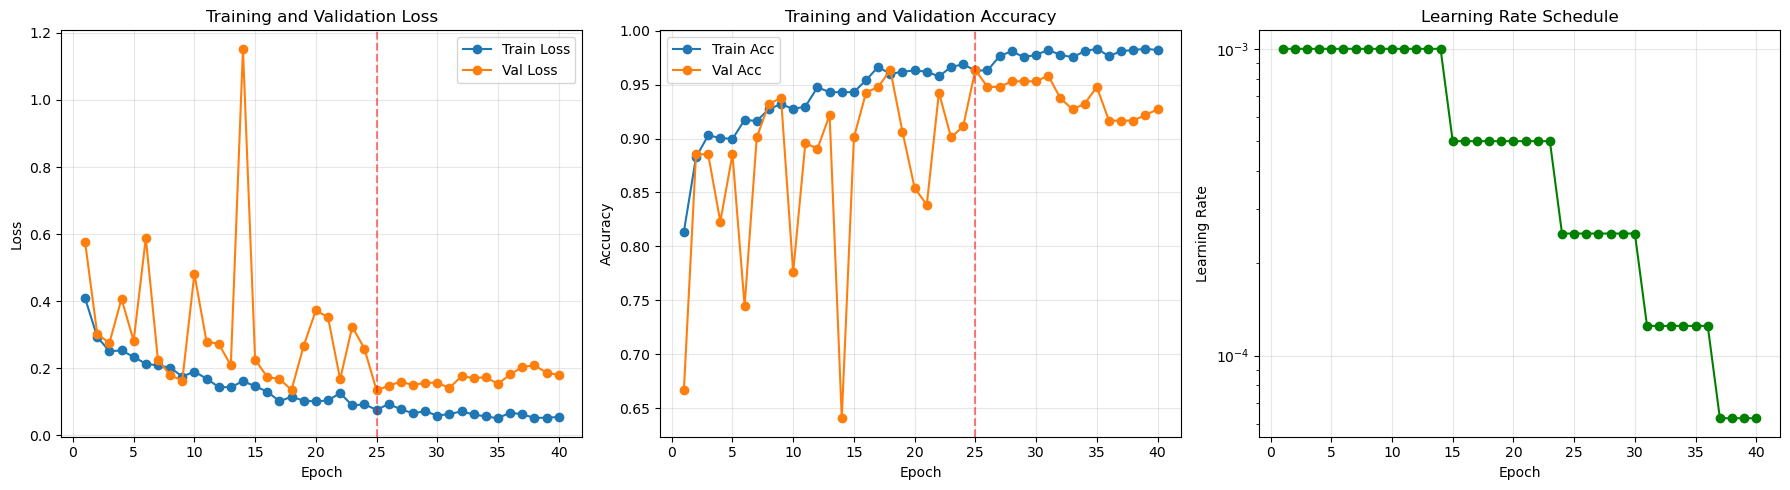


✓ Best epoch: 25 (Val Loss: 0.1344)


In [7]:
if results_file.exists():
    history = results['history']
    epochs = range(1, len(history['train_loss']) + 1)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Loss curves
    axes[0].plot(epochs, history['train_loss'], label='Train Loss', marker='o')
    axes[0].plot(epochs, history['val_loss'], label='Val Loss', marker='o')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    axes[0].axvline(x=results['best_epoch'], color='r', linestyle='--', alpha=0.5, label='Best Epoch')
    
    # Accuracy curves
    axes[1].plot(epochs, history['train_acc'], label='Train Acc', marker='o')
    axes[1].plot(epochs, history['val_acc'], label='Val Acc', marker='o')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    axes[1].axvline(x=results['best_epoch'], color='r', linestyle='--', alpha=0.5)
    
    # Learning rate
    axes[2].plot(epochs, history['learning_rates'], marker='o', color='green')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Learning Rate')
    axes[2].set_title('Learning Rate Schedule')
    axes[2].set_yscale('log')
    axes[2].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ Best epoch: {results['best_epoch']} (Val Loss: {history['val_loss'][results['best_epoch']-1]:.4f})")

## 7. Display Full Evaluation Visualization

Simple CNN Training Results:



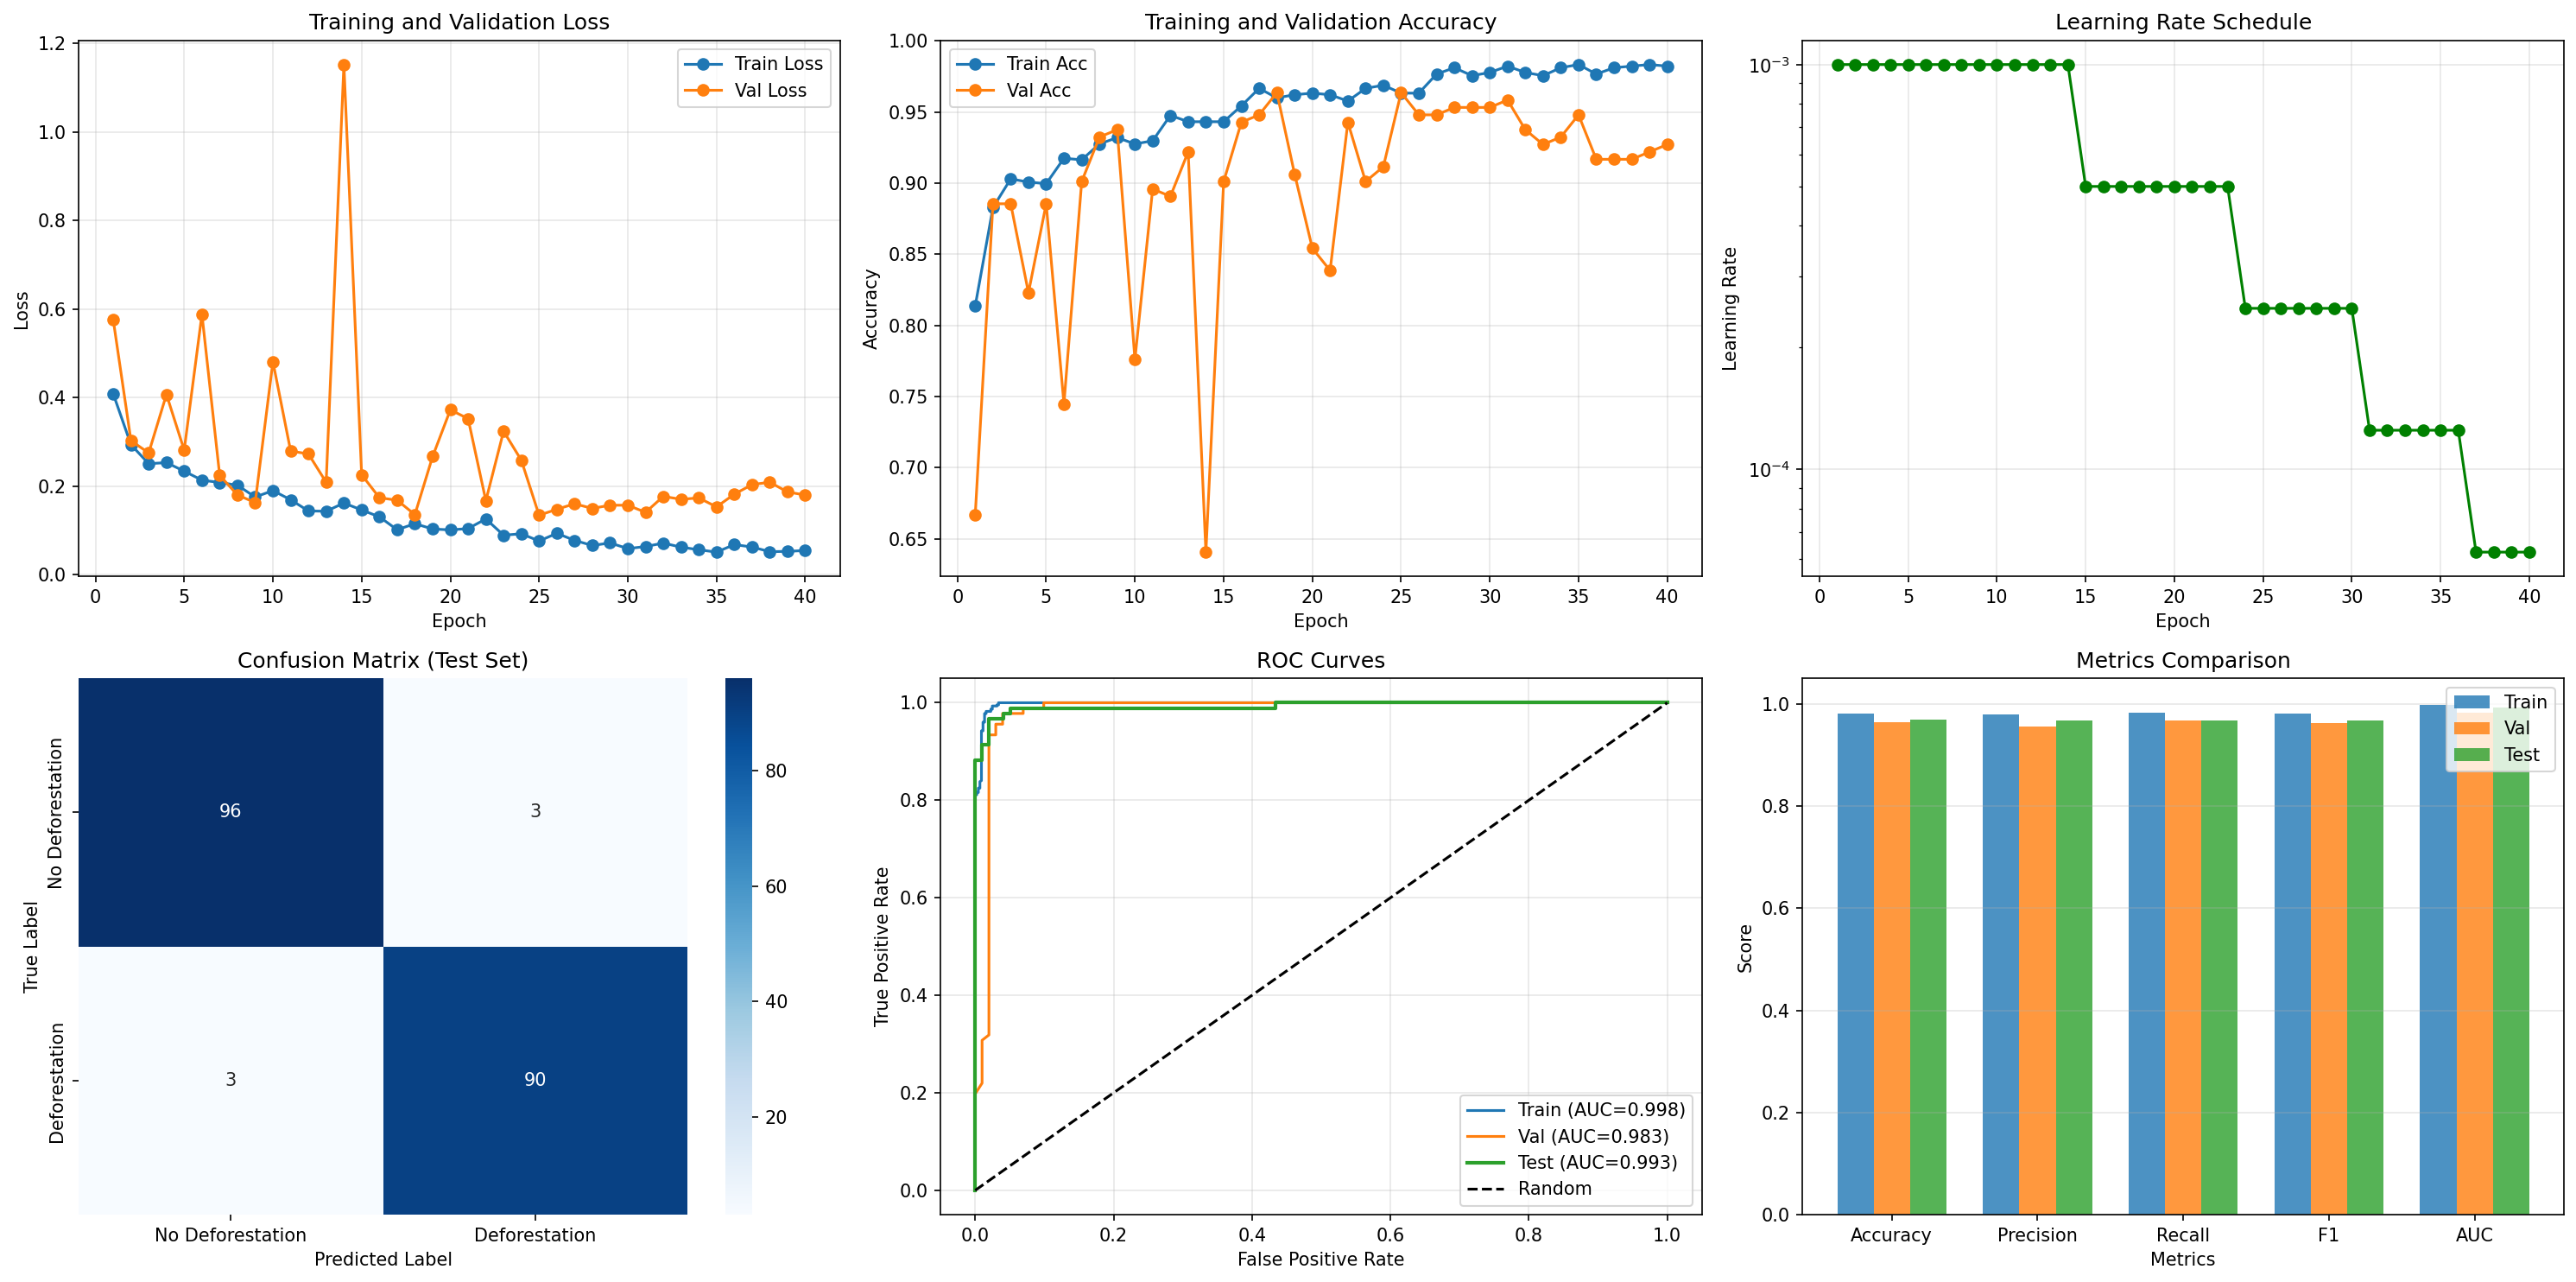

In [8]:
from IPython.display import Image, display

eval_fig = Path('../figures/simple_cnn_training.png')
if eval_fig.exists():
    print("Simple CNN Training Results:\n")
    display(Image(filename=str(eval_fig)))
else:
    print("Evaluation figure not found. Please train the model first.")

## 8. Confusion Matrix Analysis

In [9]:
if results_file.exists():
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    
    y_test_true = np.array(results['predictions']['test']['y_true'])
    y_test_pred = np.array(results['predictions']['test']['y_pred'])
    
    cm = confusion_matrix(y_test_true, y_test_pred)
    
    print("\nConfusion Matrix (Test Set):")
    print("="*70)
    print(f"\n{' ':20} Predicted No Def    Predicted Def")
    print(f"True No Deforestation:   {cm[0,0]:8d}          {cm[0,1]:8d}")
    print(f"True Deforestation:      {cm[1,0]:8d}          {cm[1,1]:8d}")
    
    # Calculate per-class metrics
    tn, fp, fn, tp = cm.ravel()
    print(f"\nPer-class Analysis:")
    print(f"  True Negatives (TN):  {tn:4d} - Correctly predicted No Deforestation")
    print(f"  False Positives (FP): {fp:4d} - Incorrectly predicted Deforestation")
    print(f"  False Negatives (FN): {fn:4d} - Missed Deforestation (Type II error)")
    print(f"  True Positives (TP):  {tp:4d} - Correctly detected Deforestation")
    
    print(f"\n  Sensitivity (Recall): {tp/(tp+fn):.4f} - % of actual deforestation detected")
    print(f"  Specificity:          {tn/(tn+fp):.4f} - % of actual no-deforestation detected")


Confusion Matrix (Test Set):

                     Predicted No Def    Predicted Def
True No Deforestation:         96                 3
True Deforestation:             3                90

Per-class Analysis:
  True Negatives (TN):    96 - Correctly predicted No Deforestation
  False Positives (FP):    3 - Incorrectly predicted Deforestation
  False Negatives (FN):    3 - Missed Deforestation (Type II error)
  True Positives (TP):    90 - Correctly detected Deforestation

  Sensitivity (Recall): 0.9677 - % of actual deforestation detected
  Specificity:          0.9697 - % of actual no-deforestation detected


## 9. Kết luận

✅ **Simple CNN đã được train thành công!**

### Điểm mạnh:
- 🧠 Tự động học features từ raw images
- 🎯 Capacity cao hơn Random Forest
- 📈 Có thể improve với data augmentation
- 🔄 Có thể mở rộng sang Phase 2 (advanced architectures)

### Điểm yếu:
- ⏱️ Training chậm (~2-4 giờ vs 5 phút RF)
- 💻 Cần GPU để training hiệu quả
- 🔍 Khó interpret hơn RF
- ⚠️ Có thể overfit với dataset nhỏ (899 samples)

### Tiếp theo:
- ▶️ **Notebook 05:** So sánh Random Forest vs Simple CNN
- Xem model nào perform tốt hơn
- Quyết định có nên tiếp tục Phase 2 hay không